In [1]:

from bmtool.analysis import spikes, lfp
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as ss

config_path = '/home/gjgpb9/cortex_modeling/V1_Layer5/Model-Parameters/simulation_config_baseline.json'
output_path = '/home/gjgpb9/cortex_modeling/V1_Layer5/Run-Storage/final_result_2/block1/long'
fs = 400

df = spikes.load_spikes_to_df(spike_file=f'{output_path}/spikes.h5',network_name='cortex',config=config_path)
spike_rate = spikes.get_population_spike_rate(df,config=config_path,fs=fs)

ecp = lfp.load_ecp_to_xarray(ecp_file=f'{output_path}/ecp.h5')
lfp_processed = lfp.ecp_to_lfp(ecp_data=ecp,downsample_freq=fs)

Grabbing first network; specify a network name to ensure correct node population is selected.



FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 100 Hz                        
                                 Frequency Resolution is 1.56 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -4.8350, 1.2181                                          
                                                                                                  
                             

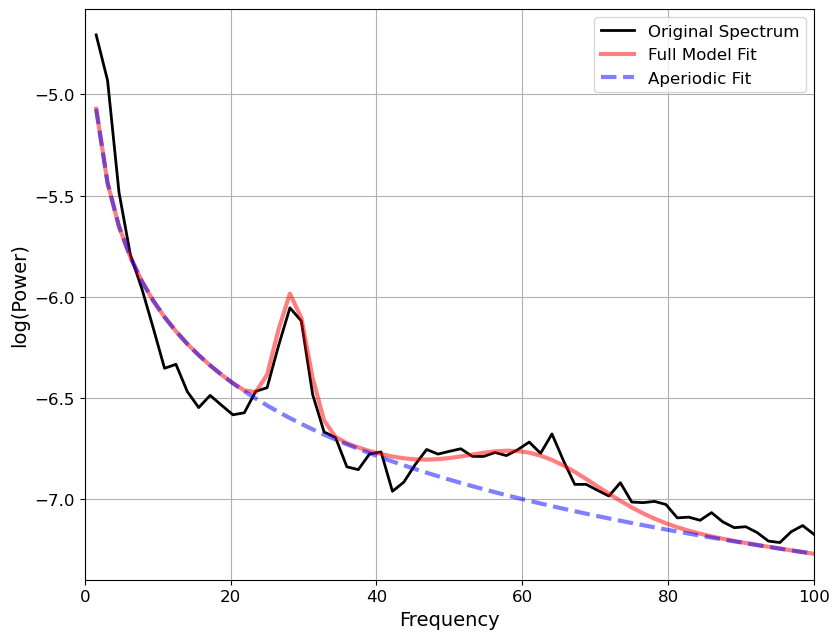

In [2]:
hz, pxx = ss.welch(x=lfp_processed,fs=fs)
results = lfp.fit_fooof(f=hz,pxx=pxx[0],plot=True,report=True,freq_range=[0,100],plt_log=False,plt_range=[0,100])

In [3]:
# hz, pxx = ss.welch(x=spike_rate['FSI'],fs=fs)
# results = lfp.fit_fooof(f=hz,pxx=pxx,plot=True,report=True,freq_range=[0,100],plt_log=False,plt_range=[0,100])

In [4]:
# hz, pxx = ss.welch(x=spike_rate['LTS'],fs=fs)
# results = lfp.fit_fooof(f=hz,pxx=pxx,plot=True,report=True,freq_range=[0,100],plt_log=False,plt_range=[0,100])

### Makes sure to change the freq_of_interest to be the center frequency of your oscillation

In [5]:
freq = 28
plv = lfp.calculate_ppc(df[df['pop_name']=='FSI']['timestamps'].values,lfp_processed[0],spike_fs=1000,lfp_fs=400,freq_of_interest=freq,method='wavelet',ppc_method='gpu')
print(plv)
plv = lfp.calculate_ppc(df[df['pop_name']=='LTS']['timestamps'].values,lfp_processed[0],spike_fs=1000,lfp_fs=400,freq_of_interest=freq,method='wavelet',ppc_method='gpu')
print(plv)

0.0008368040581938121
0.01931643375571338


### You can also plot the entrainment for different frequencies 

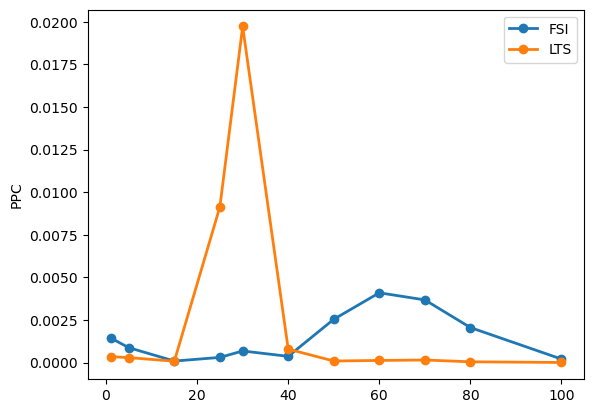

In [6]:
freqs = [1,5,15,25,30,40,50,60,70,80,100]
plv_list_FSI = []
plv_list_LTS = []

for i in range(len(freqs)):
    plv_list_FSI.append(lfp.calculate_ppc(df[df['pop_name']=='FSI']['timestamps'].values,lfp_processed[0],spike_fs=1000,lfp_fs=400,freq_of_interest=freqs[i],method='wavelet',ppc_method='gpu'))
    plv_list_LTS.append(lfp.calculate_ppc(df[df['pop_name']=='LTS']['timestamps'].values,lfp_processed[0],spike_fs=1000,lfp_fs=400,freq_of_interest=freqs[i],method='wavelet',ppc_method='gpu'))
    
plt.plot(freqs,plv_list_FSI,'o-', linewidth=2,label="FSI")
plt.plot(freqs,plv_list_LTS,'o-', linewidth=2,label='LTS')
plt.ylabel("PPC")
plt.legend()
plt.show()

# we can see that our FSI cells are around gamma and our LTS cells are around beta which is a good result to see

### where the cells spike in gamma cycle 

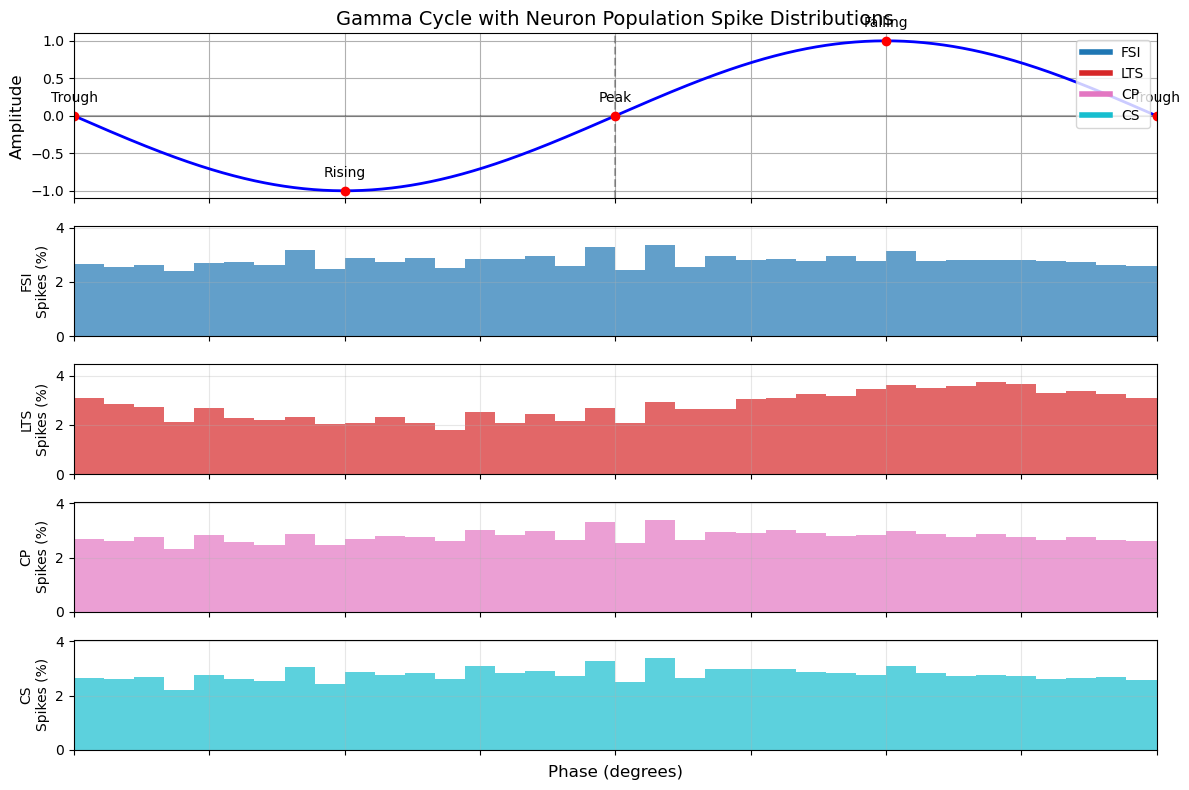

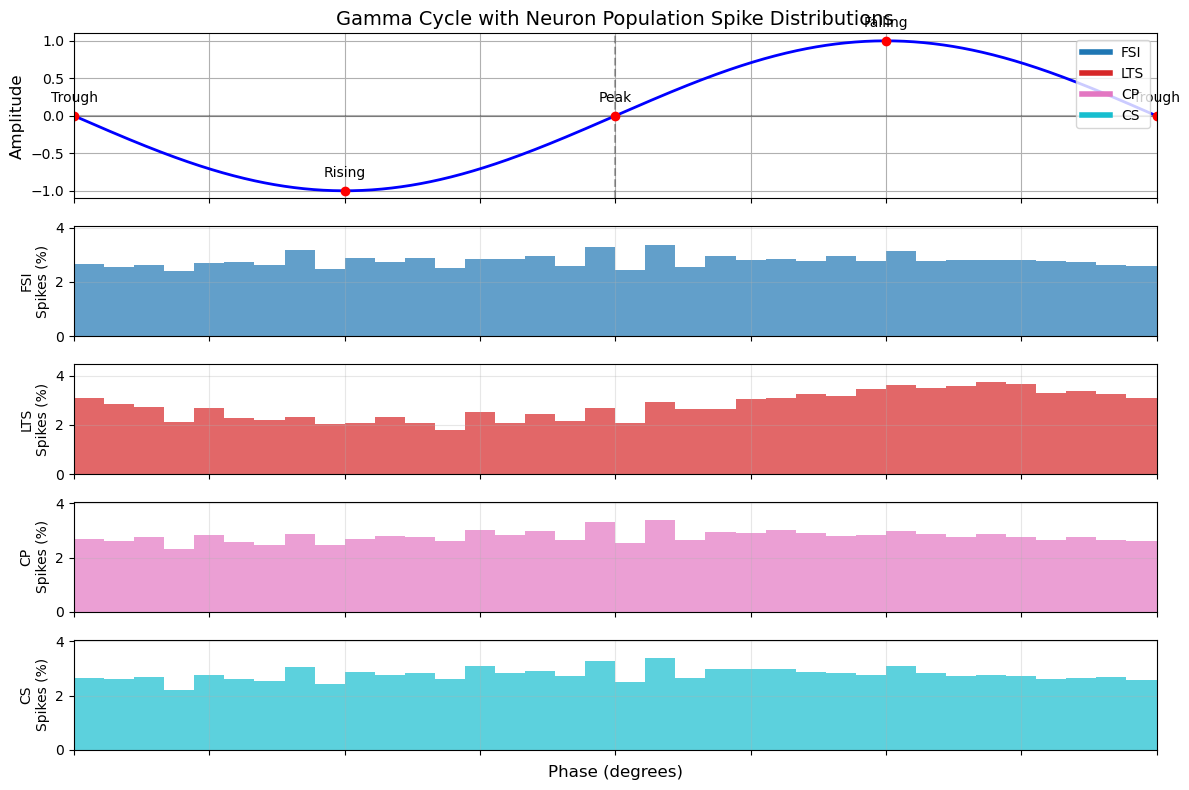

In [7]:
from bmtool.analysis.lfp import butter_bandpass_filter
from matplotlib.gridspec import GridSpec

def get_spikes_in_cycle(spike_df, lfp_data, spike_fs = 1000, lfp_fs=400, band=(30, 80)):
    """
    Analyze spike timing relative to oscillation phases.
    
    Parameters:
    -----------
    spike_df : pd.DataFrame
    lfp_data : np.array
        Raw LFP signal
    fs : float
        Sampling frequency of LFP in Hz
    gamma_band : tuple
        Lower and upper bounds of gamma frequency band in Hz
    
    Returns:
    --------
    phase_data : dict
        Dictionary containing phase values for each spike and neuron population
    """
    filtered_lfp = butter_bandpass_filter(lfp_data, band[0], band[1], lfp_fs)
    
    # Calculate phase using Hilbert transform
    analytic_signal = ss.hilbert(filtered_lfp)
    phase = np.angle(analytic_signal)
    amplitude = np.abs(analytic_signal)
    
    # Get unique neuron populations
    neuron_pops = spike_df['pop_name'].unique()
    
    # Get the phase at each spike time for each neuron population
    phase_data = {}
    
    for pop in neuron_pops:
        # Get spike times for this population
        pop_spikes = spike_df[spike_df['pop_name'] == pop]['timestamps'].values
        if spike_fs == None:
            spike_fs = lfp_fs
        # Convert spike times to sample indices
        spike_times_seconds = pop_spikes / spike_fs

        # Then convert from seconds to samples at the new sampling rate
        spike_indices = np.round(spike_times_seconds * lfp_fs).astype(int)
        
        # Ensure spike times are within LFP data range
        valid_indices = (spike_indices >= 0) & (spike_indices < len(phase))
        
        if np.any(valid_indices):
            valid_samples = spike_indices[valid_indices]
            phase_data[pop] = phase[valid_samples]
    
    return phase_data, filtered_lfp, phase, amplitude
    
def plot_cycle_with_spike_histograms(phase_data, fs=400, bins=36):
    """
    Plot an idealized gamma cycle with spike histograms for different neuron populations.
    
    Parameters:
    -----------
    phase_data : dict
        Dictionary containing phase values for each spike and neuron population
    fs : float
        Sampling frequency of LFP in Hz
    bins : int
        Number of bins for the phase histogram (default 36 gives 10-degree bins)
    """
    # Get unique neuron populations
    neuron_pops = list(phase_data.keys())
    n_pops = len(neuron_pops)
    
    # Create a figure with subplots
    fig = plt.figure(figsize=(12, 8))
    gs = GridSpec(n_pops+1, 1, height_ratios=[1.5] + [1]*n_pops)
    
    # Top subplot: Idealized gamma cycle
    ax_gamma = fig.add_subplot(gs[0])
    
    # Create an idealized gamma cycle
    x = np.linspace(-np.pi, np.pi, 1000)
    y = np.sin(x)
    
    ax_gamma.plot(x, y, 'b-', linewidth=2)
    ax_gamma.set_title('Gamma Cycle with Neuron Population Spike Distributions', fontsize=14)
    ax_gamma.set_ylabel('Amplitude', fontsize=12)
    ax_gamma.set_xlim(-np.pi, np.pi)
    ax_gamma.set_xticks(np.linspace(-np.pi, np.pi, 9))
    ax_gamma.set_xticklabels(['-180°', '-135°', '-90°', '-45°', '0°', '45°', '90°', '135°', '180°'])
    ax_gamma.grid(True)
    ax_gamma.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    ax_gamma.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    
    # Mark key phase points
    phase_points = {
        0: 'Peak',
        np.pi/2: 'Falling',
        -np.pi/2: 'Rising',
        np.pi: 'Trough',
        -np.pi: 'Trough'
    }
    
    for phase, label in phase_points.items():
        ax_gamma.plot(phase, np.sin(phase), 'ro', markersize=6)
        ax_gamma.annotate(label, (phase, np.sin(phase)), xytext=(0, 10), 
                         textcoords='offset points', ha='center')
    
    # Generate a color map for the different populations
    colors = plt.cm.tab10(np.linspace(0, 1, n_pops))
    
    # Add histograms for each neuron population
    for i, (pop, phases) in enumerate(phase_data.items()):
        ax_hist = fig.add_subplot(gs[i+1], sharex=ax_gamma)
        
        # Compute histogram
        hist, bin_edges = np.histogram(phases, bins=bins, range=(-np.pi, np.pi))
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        # Normalize histogram
        if np.sum(hist) > 0:
            hist = hist / np.sum(hist) * 100  # Convert to percentage
        
        # Plot histogram
        ax_hist.bar(bin_centers, hist, width=2*np.pi/bins, alpha=0.7, color=colors[i])
        ax_hist.set_ylabel(f'{pop}\nSpikes (%)', fontsize=10)
        
        # Add grid to align with gamma cycle
        ax_hist.grid(True, alpha=0.3)
        ax_hist.set_ylim(0, max(hist) * 1.2)  # Add some headroom
        
        # Remove x-tick labels for all but the last subplot
        if i < n_pops - 1:
            ax_hist.set_xticklabels([])
    
    # Set x-label for the last subplot
    ax_hist.set_xlabel('Phase (degrees)', fontsize=12)
    
    # Add legend to the top subplot
    custom_lines = [plt.Line2D([0], [0], color=colors[i], lw=4) for i in range(n_pops)]
    ax_gamma.legend(custom_lines, neuron_pops, loc='upper right')
    
    plt.tight_layout()
    return fig    

phase_data, filtered_lfp, phase, amplitude = get_spikes_in_cycle(df,lfp_processed[0],spike_fs=1000,lfp_fs=400,band=(20,30))

plot_cycle_with_spike_histograms(phase_data)